## Make detailed maps with HUC2 boundaries  
_DTT, adapted from Yueling Ma_  
  
This notebook creates figures of data mapped over HUC2 and country boundaries. The resulting figure is a scatter plot of data by latitude and longitude with a variable specified for the color of the scatter plot.  

Inputs:
- CSV of data to be plotted. As of now, this mainly comes from previous scripts that calculate stats on PFCLM variables compared to observations (e.g., `compare_SNOTEL_temp.ipynb` or `2_SaveStreamflowStats.ipynb`)
- User defined inputs (water year, plot names and variables, corner lat/long for bounding box)
- Already defined here, but worth checking the file paths:
  -  CONUS2 lat and long files (`Latitude_CONUS2.pfb`, `Longitude_CONUS2.pfb`)
  -  CONUS2 HUC2 boundary tif file (`CONUS2.0.Final1km.Subbasin_HUC2.remapped.tif`)

In [1]:
import numpy as np
import pandas as pd
from PIL import Image

from parflow.tools.io import read_pfb

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap # BASEMAP PACKAGE ONLY REQUIRED FOR PART 1 MAP!

# from matplotlib.colors import ListedColormap

##### Other CSV paths (just for ease of use)
Streamflow: `'/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/Streamflow/\
Organized_Daily_Flow/Summary_Gages_CONUS2_WY2003.csv'`  

SNOTEL Precip: `'/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/SNOTEL/\
precip_temp/Organized_csv/precip/Summary_Stations_CONUS2_SNOTEL_Precip_tot_WY2003.csv'`

In [2]:
water_year = 2003

In [3]:
### CSV of saved data that will be plotted ###
data_csv_path = '/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/Streamflow/Organized_Daily_Flow/Summary_Gages_CONUS2_WY2003.csv'
stats_df = pd.read_csv(data_csv_path)
# check the data you loaded
stats_df.head()

,site_id,latitude,longitude,conus2_x,conus2_y,huc,HUC2,USGS_mean_cms,PF_mean_cms,pf_minus_obs,absrelbias,bias,pbias,srho,r2,rmse,mse
0,1010000,46.700556,-69.715556,4181,2731,1010001,1,54.732510,21.812227,-12015.903320,0.601476,-0.601476,-60.147585,0.859089,0.194915,77.527725,6010.548221
1,1010070,46.893889,-69.751667,4172,2746,1010001,1,9.014225,2.360176,-2428.727876,0.738172,-0.738172,-73.817209,0.697101,0.161414,14.367161,206.415312
2,1010500,47.113056,-69.088056,4209,2784,1010001,1,104.191141,51.536925,-19218.788658,0.505362,-0.505362,-50.536173,0.795350,0.387808,126.564636,16018.606962
3,1011000,47.069722,-69.079444,4210,2783,1010002,1,41.836549,29.714315,-4424.615543,0.289752,-0.289752,-28.975225,0.706543,0.598717,36.749715,1350.541531
4,1013500,47.237500,-68.582778,4237,2810,1010003,1,39.405556,18.607378,-7591.334817,0.527798,-0.527798,-52.779810,0.517411,0.220357,44.114798,1946.115399


#### Define plot title, plot_var, saving location, saved plot file name

In [4]:
### Here, define everything specific to the plot variables
### This includes: 
### - directory where plots are saved to (plot_dir)
### - variable you want to plot as a color in the scatter plot (plot_var)
### - plot title to be displayed on plot (plot_title)
### - name to save plot file as (plot_to_save)


## location where plots are being saved ##
plot_dir = '/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/Streamflow/'
#plot_dir = '/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/SNOTEL/precip_temp/Figures/summary_plots_precip'

## Variable you want to plot (this will show up as the scatter plot colormap) ##
plot_var = stats_df['pf_minus_obs']

## Plot title ##
plot_title = f'Daily Streamflow Difference (PF-CONUS2 - USGS) WY{water_year}'
#plot_title = f'WY{water_year} PFCONUS2 Streamflow Relative Bias'
#plot_title = f'WY{water_year} CW3E vs SNOTEL Precip Relative Bias'

## Name of file for plot to save ##
plot_to_save = f'PFCONUS2_StreamflowDiff_PF-USGS_WY{water_year}.png'#HUC2boundaries.png'
#plot_to_save = f'CW3E_SNOTEL_precip_WY{water_year}_RelBias_WesternUSMap.png'

print(f'Figure will be saved as: {plot_to_save}')
print(f'in the directory: {plot_dir}')

Figure will be saved as: PFCONUS2_StreamflowDiff_PF-USGS_WY2003.png
in the directory: /hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/Streamflow/


## 1. Matplotlib Basemap Plotting
This maps a nice figure with lat/long labeled and meridians and HUC2 boundaries (etc.) plotted  
This requires the package Basemap to be loaded and this is currently NOT in the parflow-ml env on Verde  
`from mpl_toolkits.basemap import Basemap`

In [22]:
#### define longitude and latitude corner boundaries for map bounds in Basemap 
# CONUS2: ur_lat = 49, ur_lon = -64, ll_lat = 22, ll_lon = -119 (this cuts part of the Columbia R Basin now)
# CONUS2: central_lon = -95, no central latitude

### CONUS2 MAP ###
ll_lon = -119
ll_lat = 22
ur_lon = -64
ur_lat = 49
# central lat and long
central_lon = -95

### WESTERN US REGIONAL MAP ###
# ll_lon = -123
# ll_lat = 30
# ur_lon = -102
# ur_lat = 50
# # central lat and long, good for if you want to zoom in on an area (e.g. western US)
# central_lat = 40
# central_lon = -111

In [23]:
# Maybe helpful for vmin and vmax
print(f'plot_var maximum: {plot_var.max()}')
print(f'plot_var minimum: {plot_var.min()}')

plot_var maximum: 501896.885179908
plot_var minimum: -2376575.259631489


_________________
#### Below this, user can make changes to the script (such as changing the `m1.scatter` plot colormap (`cmap`), `vmin` & `vmax`, or other figure details), but shouldn't need to if everything above is correct.  
_________________

In [24]:
#CONUS2 coordinates 
lats_CONUS2 = np.squeeze(read_pfb('/hydrodata/national_mapping/CONUS2/Latitude_CONUS2.pfb'),axis=0)
lons_CONUS2 = np.squeeze(read_pfb('/hydrodata/national_mapping/CONUS2/Longitude_CONUS2.pfb'),axis=0)

huc2_tif = '/hydrodata/national_mapping/CONUS2/CONUS2.0.Final1km.Subbasin_HUC2.remapped.tif'

# open HUC2 tif
im = Image.open(huc2_tif) 
# make HUC2 tif into numpy array
imarray = np.array(im) 
print(f'Domain dimensions of tif array: {imarray.shape}')
# make tif correct orientation (flip vertically)
tiff_numpy = np.flipud(imarray)

Domain dimensions of tif array: (3256, 4442)


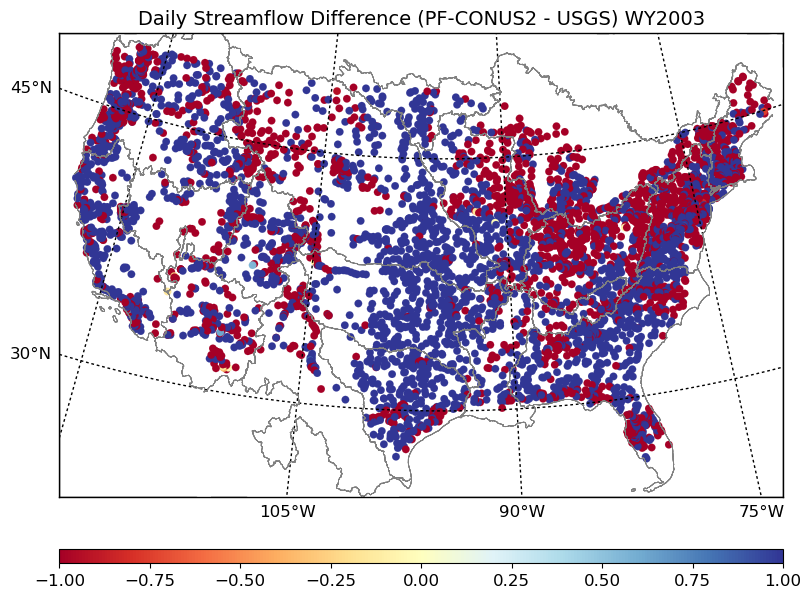

In [25]:
fig, ax1 = plt.subplots(1,1,figsize=(8,6),constrained_layout=True)

# these lat/long coordinates are boundaries of map to visualize (defined above) 
m1 = Basemap(llcrnrlon=ll_lon,llcrnrlat=ll_lat,urcrnrlon=ur_lon,urcrnrlat=ur_lat,\
             projection='lcc',lat_1=33,lat_2=45,lon_0=central_lon, ax=ax1) #  lat_0 = central_lat,  (not used for CONUS, but need for WESTERN US)


#point coordinates for what is being mapped
lons1, lats1 = m1(stats_df.longitude,stats_df.latitude)

lons_basin, lats_basin = m1(lons_CONUS2,lats_CONUS2)

##Draw coastlines & countries
#m1.drawcoastlines(color='k',linewidth=0.8)
#m1.drawcountries(color='k',linewidth=0.8)

#Draw parallels and meridians
m1.drawparallels(np.arange(-90.,91.,15.),labels=[True,False,False,False],dashes=[2,2],fontsize=12)
m1.drawmeridians(np.arange(-180.,181.,15.),labels=[False,False,False,True],dashes=[2,2],fontsize=12)

m1.fillcontinents(color='white',lake_color='white')
m1.drawmapboundary(fill_color='white')

im1 = m1.scatter(lons1,lats1,c=plot_var,s=30,linewidths=0.1,cmap='RdYlBu',vmin = -1, vmax = 1)# ,alpha=.9

ax1.set_title(plot_title,fontsize=14) 

cbar1 = plt.colorbar(im1,ax=ax1,shrink=1,aspect=50,orientation='horizontal')#,\
                     #label = 'positive: PF overestimate, negative: PF underestimate')#,
cbar1.ax.tick_params(labelsize=12)

#Draw river basins
for water_basin_index in range(1,19):
    mask_index = np.where(tiff_numpy==water_basin_index)
    mask_arr = np.zeros([tiff_numpy.shape[0],tiff_numpy.shape[1]])
    mask_arr[mask_index] = 1
    
    m1.contour(lons_basin,lats_basin,mask_arr,colors='grey',linewidths=0.5)

plt.savefig(f'{plot_dir}/DetailMap_{plot_to_save}',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

## 2. Plots using png of CONUS2 HUC map (alternative to the above method)  
Plots a simple map of points with color (defined above by `plot_var`) with HUC2 outlines  
*User will need to change `vmin` and `vmax` to make sure colors are scaled correctly*

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from parflow.tools.io import read_pfb

In [5]:
# Read in CONUS2 mask and HUC2 png for map plot border and HUC2 outlines
CONUS2_mask = Image.open('/hydrodata/PFCLM/CONUS2_baseline/inputs/domain_files/CONUS2.0.Final1km.Mask.tif')
mask_array = np.array(CONUS2_mask)
HUC2_outline = Image.open('CONUS2_outline_with_HUC2_noSqrBorder.png')#Should be in same directory as this notebook

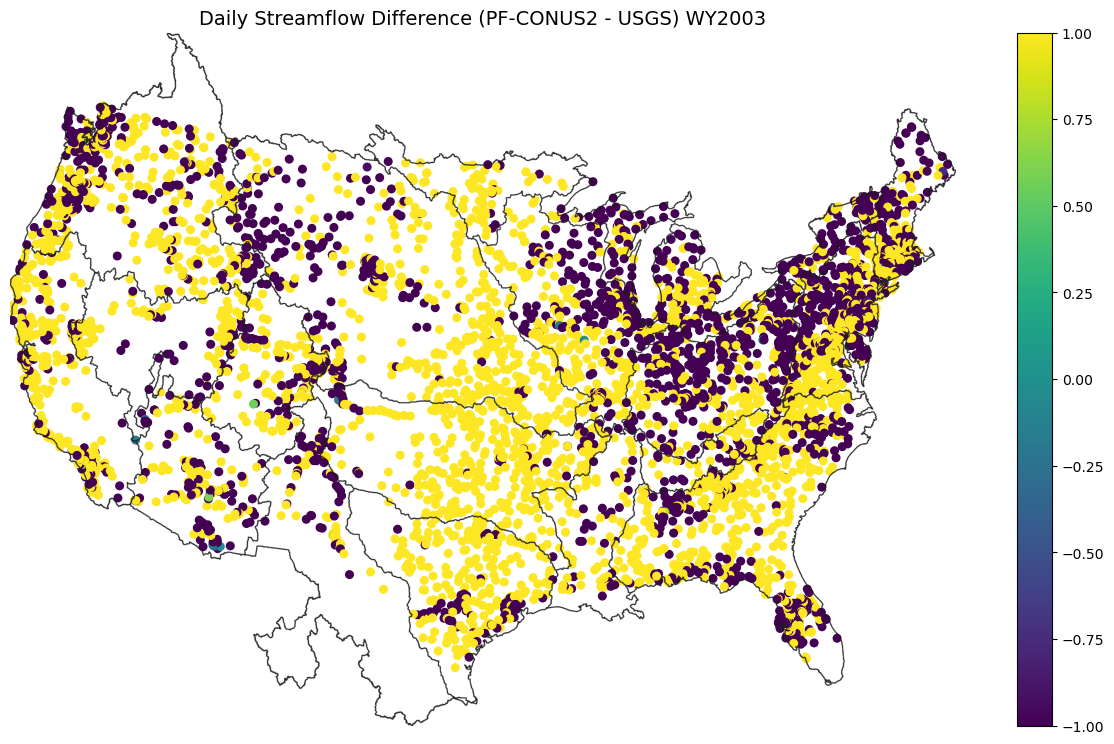

In [8]:
#Plotting over an image of the CONUS domain
fig, ax = plt.subplots(1,1,figsize=(16,9))
im = ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=plot_var, zorder=1, s=30, vmax = 1, vmin = -1) #
plt.title(plot_title,fontsize=14) 
plt.colorbar(points)
plt.axis('off')
plt.savefig(f'{plot_dir}/HUC2_outline_{plot_to_save}',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

##### Same as the plot above, but with a border around the CONUS2 domain and grey backgound

(-0.5, 4442.0, -0.5, 3256.0)

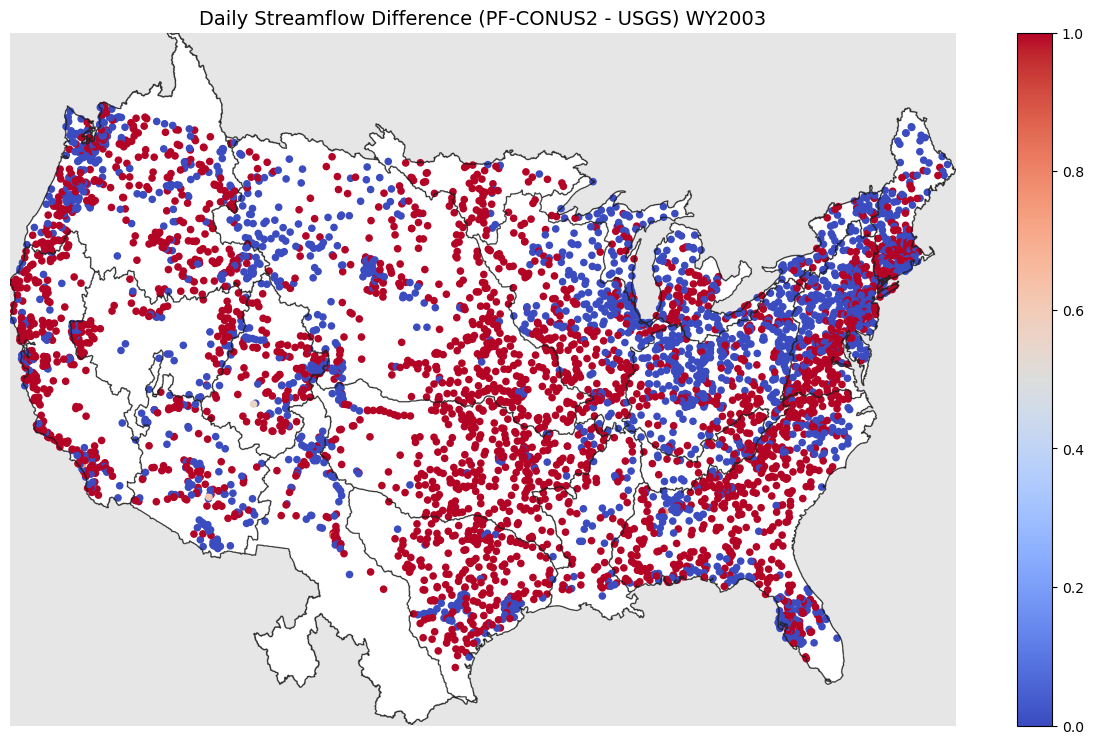

In [9]:
#Plotting over an image of the CONUS domain with grey background
fig, ax = plt.subplots(1,1,figsize=(16,9))
ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
ax.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=plot_var, cmap='coolwarm', s=20, vmin = 0, vmax = 1, zorder=1)
plt.title(plot_title, fontsize=14) 
plt.colorbar(points)#, label = 'absolute relative bias'
plt.axis('off')
# plt.savefig(f'{plot_dir}/HUC2_outline_border{plot_to_save}',\
#             dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

## Example code for creating a figure with multiple subplots (e.g. subsurface layers)
To note, this uses different file inputs from the above examples, but I wanted to keep the helpful plotting code in one place.  
Like the above two plots with overlay onto the PNG, the `zorder` is important to ensure that layers are ordered correctly when plotting. For example, having the HUC2 outlines on top (`zorder = 2`) of the data you are mapping (`zorder = 1`).

In [17]:
import matplotlib as mpl

In [18]:
sub_file = read_pfb('/hydrodata/PFCLM/CONUS2_baseline/inputs/model_inputs/CONUS2.0.Final1km.Subsurface.pfb')

In [19]:
# create mask for blocking out inactive area in plots
active_mask=mask_array.copy()
active_mask[active_mask == 1] = 'nan'
active_mask[active_mask == 0] = 1
print(active_mask[3255,4441]) # print inactive domain. should be nan, because using this to block out inactive domain)
print(active_mask[2000,2000]) # print active domain, just for fun 

1.0
nan


In [20]:
indicator_labels = ['lower permeability bedrock','higher permeability bedrock','fine grain silicate sedimentary',\
                    'silicate sedimentary','crystalline','fine grain unconsolidated','unconsolidated',\
                    'coarse grain sedimentary & volcanic','carbonate','coarse grain unconsolidated',]

[Text(1, 19, 'lower permeability bedrock'),
 Text(1, 20, 'higher permeability bedrock'),
 Text(1, 21, 'fine grain silicate sedimentary'),
 Text(1, 22, 'silicate sedimentary'),
 Text(1, 23, 'crystalline'),
 Text(1, 24, 'fine grain unconsolidated'),
 Text(1, 25, 'unconsolidated'),
 Text(1, 26, 'coarse grain sedimentary & volcanic'),
 Text(1, 27, 'carbonate'),
 Text(1, 28, 'coarse grain unconsolidated')]

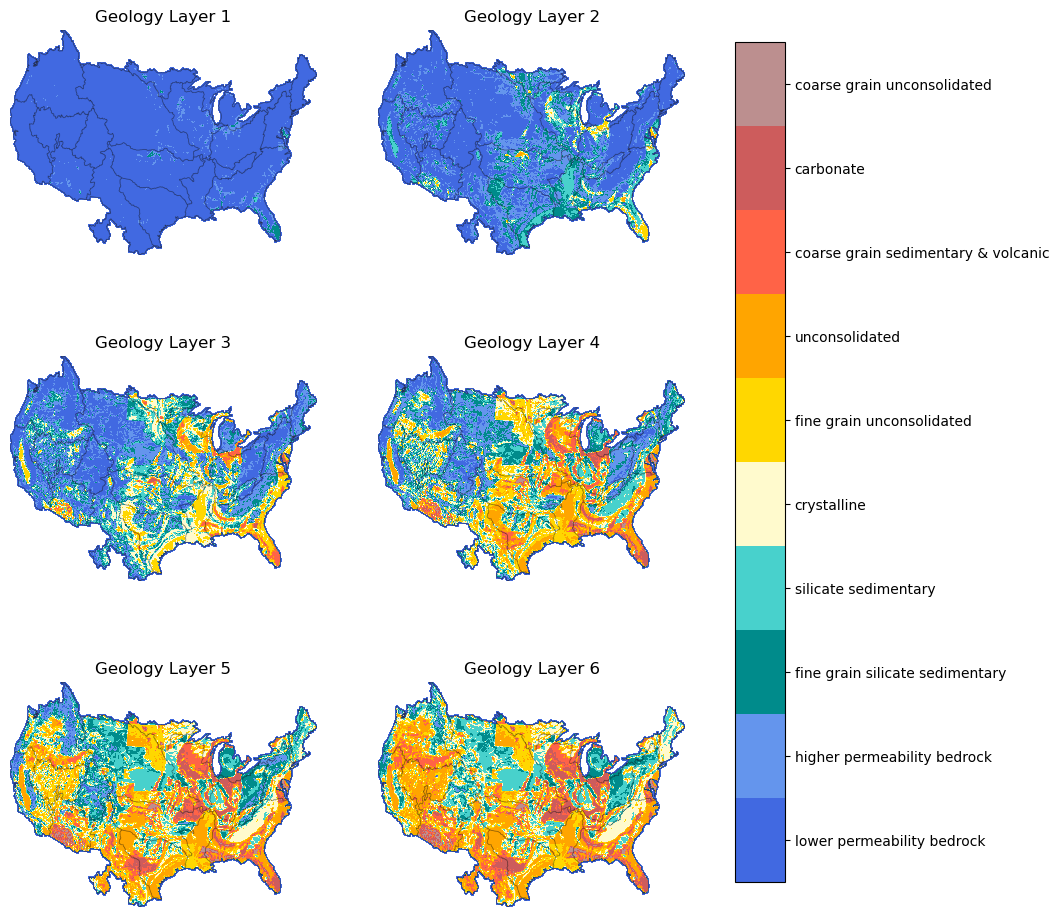

In [21]:
# final subsurface, all 6 layers

fig = plt.figure(figsize=(10,12))
cmap = (mpl.colors.ListedColormap(['royalblue','cornflowerblue','darkcyan', 'mediumturquoise','lemonchiffon','gold', 'orange','tomato','indianred','rosybrown']))
for i in range(6):
    ax = fig.add_subplot(3,2, i+1) # this line adds sub-axes
    im = ax.imshow(sub_file[i,...], origin="lower", vmin=18.5, vmax=28.5, cmap = cmap,zorder=1) # subsurface data layers
    ax.imshow(active_mask[::-1,:], origin='lower', cmap='Greys',  zorder=2) # CONUS2 outline mask (makes a white background and blocks out the inactive domain area)
    ax.imshow(HUC2_outline, extent=[0, 4441, 0, 3255],zorder=3) # HUC2 outline
    ax.set_title(f'Geology Layer {i+1}')
    plt.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.yaxis.set_ticks([19,20,21,22,23,24,25,26,27,28]) # tick marks at indicator values 
cbar.ax.set_yticklabels(indicator_labels) 
# fig.savefig(f'CONUS2_Final_6_geology_layers.png', dpi = 300, bbox_inches='tight')